In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import pandas as pd
from torch.utils.data.dataset import Dataset
from logger import Logger
from model_instance import Model_Instance


In [2]:
train_transform = transforms.Compose(
    [transforms.RandomRotation(20),
     transforms.RandomHorizontalFlip(0.3),
     transforms.ColorJitter(brightness = 0.1, # Randomly adjust color jitter of the images
                            contrast = 0.1, 
                            saturation = 0.1), 
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
test_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

def get_dataloader(batch_size):
    

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=train_transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            shuffle=True, num_workers=4)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=test_transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                            shuffle=False, num_workers=4)
    return trainloader,testloader
trainloader,testloader = get_dataloader(32)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


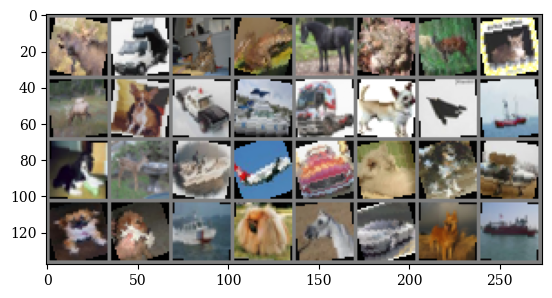

deer  truck cat   frog  horse frog  deer  cat   deer  dog   car   ship  truck dog   plane ship  dog   deer  ship  plane car   cat   dog   plane dog   dog   ship  dog   horse car   dog   ship 


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(32)))

In [3]:
@torch.no_grad()
def evaluation(model_instance,dataloader,logger=None):
  # prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}
    classes_acc={classname: 0 for classname in classes}
    correct=0
    total=0

    outcome,record_df = model_instance.run_dataloader(dataloader,update=False,display_result=False,logger=logger)
    for prediction , label in zip(outcome['pred'],outcome['label']):
        if label == prediction.argmax(axis=0):
            correct+=1
            correct_pred[classes[label]] += 1
        total_pred[classes[label]] += 1
        total+=1

    print(f'Accuracy of the network on the {total} test images: {100 * correct // total} %')
    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        classes_acc[classname]=[accuracy]
        print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')
    record_df = pd.DataFrame.from_dict(classes_acc)
    return record_df

In [4]:
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
#from resnet import get_resnet34
logger = Logger('test')
config=logger.config
config['train_step']=30000
config['valid_step']=10000
config['lr']=1e-3
config['batch_size']=512
config['device']= torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(config['device'])
# config['device']='cpu'
trainloader,testloader = get_dataloader(config.batch_size)

torch.cuda.empty_cache()
model = torchvision.models.resnet101()

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(),lr=config['lr'])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, config['train_step'])
model_instance = Model_Instance(model=model,
                                optimizer=optimizer,
                                loss_function=criterion,
                                evaluation_metrics=['acc','f1score'],
                                scheduler=scheduler,#iter
                                scheduler_epoch=False,# default False
                                device=config.device,
                                amp=False)

a=model_instance.run_step_dataloader(trainloader,
                                     run_step=config.train_step,
                                     valid_step=config.valid_step,
                                     logger=logger['Train'],
                                     evaluation_function=lambda: evaluation(model_instance,
                                                                            testloader,
                                                                            logger['Valid']))#model_instance.run_dataloader(testloader,logger=logger['Valid'],update=False))



cuda:0
Files already downloaded and verified
Files already downloaded and verified


Train  63%|████████████▋       | 62/98 [00:02<00:01, 21.75it/s]


KeyboardInterrupt: 

,experiment_name,tag,acc,f1score,loss,step
0,test,Train,0.272715,0.019747,2.080278,100.0
0,test,Train,0.338125,0.024556,1.858644,200.0
0,test,Train,0.376816,0.027406,1.741259,300.0


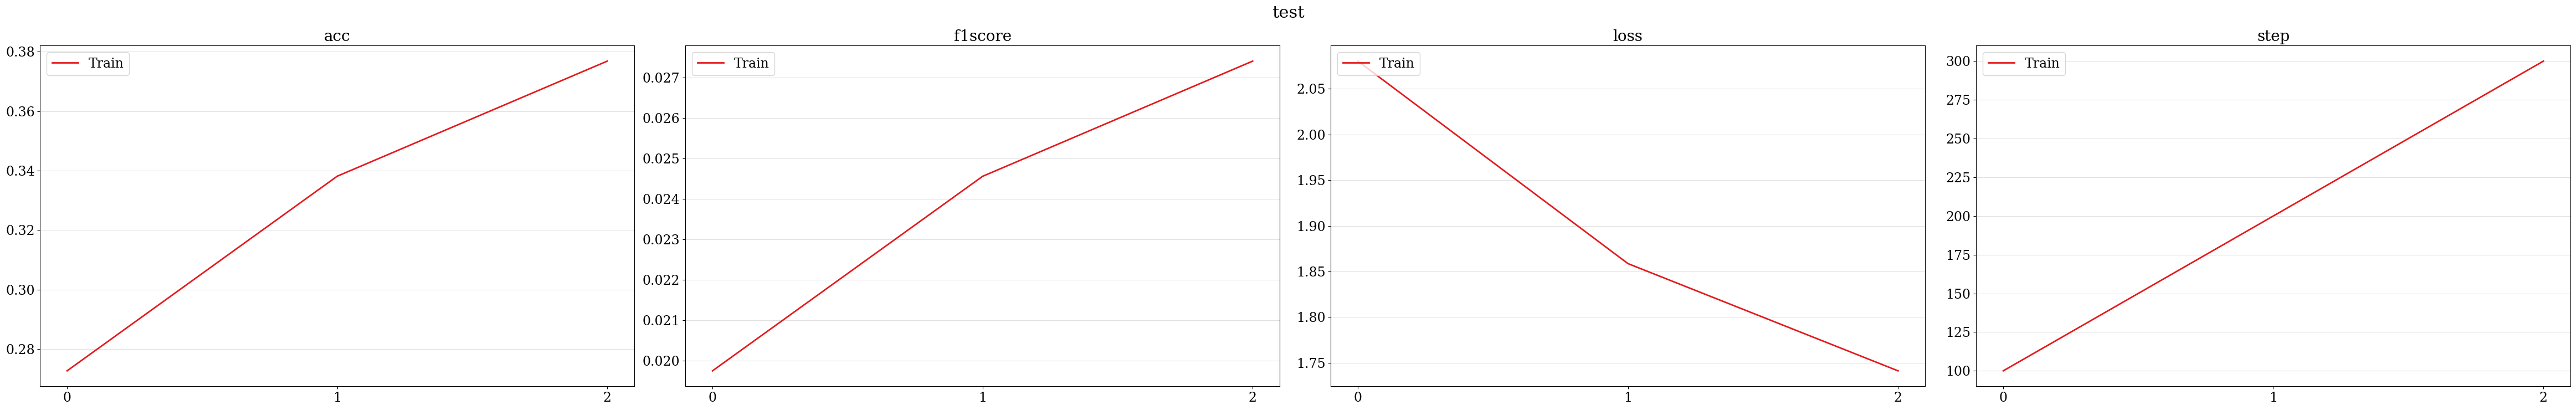

Export Success! 
 File Path:logger_file/test/logger_history


In [ ]:
display(logger.history['records'])
logger.plot_experiments()
logger.export_logger()

In [ ]:
config

{'train_step': 300,
 'valid_step': 100,
 'lr': 0.001,
 'batch_size': 512,
 'device': 'cuda:0'}